In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reading CSV file

In [4]:
df = pd.read_csv('measurement.csv',index_col='time',parse_dates=True, sep=';')
df.index = pd.to_datetime(df.index)
df.head()

,ptime,windspeed [m/s],power [relative]
time,,,
2019-11-01 01:00:00,2019-11-01,7.47,0.32
2019-11-01 02:00:00,2019-11-01,7.62,0.22
2019-11-01 03:00:00,2019-11-01,8.35,0.27
2019-11-01 04:00:00,2019-11-01,8.13,0.12
2019-11-01 05:00:00,2019-11-01,7.73,0.25


# Exploration: Data Analysis

In [8]:
print('No. of data point:',len(df))

No. of data point: 1230


In [10]:
#checking if there is any NA data or empty data 
df.isna().sum()

ptime               0
windspeed [m/s]     0
power [relative]    0
dtype: int64

In [14]:
df.describe()

,windspeed [m/s],power [relative]
count,1230.000000,1230.000000
mean,6.277439,0.190943
std,2.806720,0.199379
min,0.200000,0.000000
25%,4.250000,0.030000
50%,6.310000,0.130000
75%,8.227500,0.290000
max,16.710000,1.050000


Plotting windspeed and power

In [26]:
#Renaming the columns name for convenience
df = df.rename(columns={'windspeed [m/s]':'windspeed','power [relative]':'power'})

<AxesSubplot:title={'center':'windspeed and power plot'}, xlabel='time'>

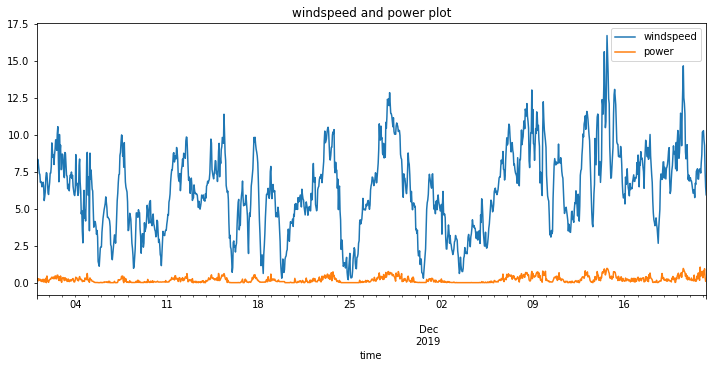

In [35]:
df.plot(figsize=(12,5),title='windspeed and power plot')


# Stationary Check

Checking if the data is stationary or not. There are different ways to check the stationarity of time series data. I am using rolling statistics and Dickey-Fuller Test.

In [28]:
#Determining rolling statistics
rolmean = df['windspeed'].rolling(window=12).mean()

rolstd = df['windspeed'].rolling(window=12).std()
print(rolmean, rolstd)

time
2019-11-01 01:00:00         NaN
2019-11-01 02:00:00         NaN
2019-11-01 03:00:00         NaN
2019-11-01 04:00:00         NaN
2019-11-01 05:00:00         NaN
                         ...   
2019-12-22 02:00:00    8.456667
2019-12-22 03:00:00    8.645833
2019-12-22 04:00:00    8.690000
2019-12-22 05:00:00    8.594167
2019-12-22 06:00:00    8.449167
Name: windspeed, Length: 1230, dtype: float64 time
2019-11-01 01:00:00         NaN
2019-11-01 02:00:00         NaN
2019-11-01 03:00:00         NaN
2019-11-01 04:00:00         NaN
2019-11-01 05:00:00         NaN
                         ...   
2019-12-22 02:00:00    1.279015
2019-12-22 03:00:00    1.211696
2019-12-22 04:00:00    1.154564
2019-12-22 05:00:00    1.291106
2019-12-22 06:00:00    1.486090
Name: windspeed, Length: 1230, dtype: float64


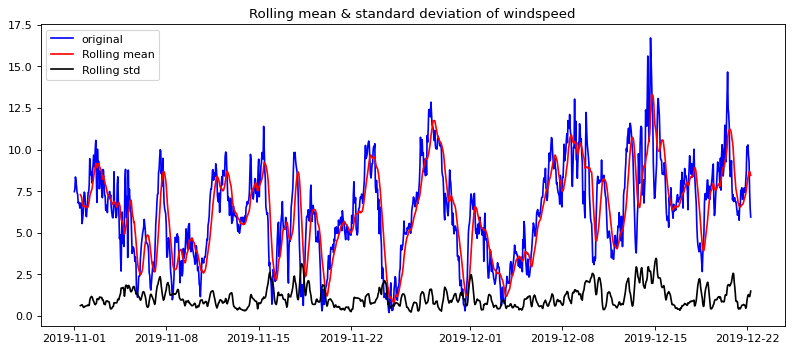

In [33]:
#Plot Rolling Statistics
plt.figure(figsize=(12,5),dpi=80)
plt.plot(df['windspeed'],color='blue',label='original')
plt.plot(rolmean, color='red', label='Rolling mean')
plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation of windspeed')
plt.show()

The Rolling statistics test gives the visual representation of the dataset.

For the dataset given, the graph of rolling mean and rolling standard deviation is constant, this shows that our 
dataset is stationary.

In [37]:
#Performing Dickey-Fuller test:


print('Results of Dickey-Fuller test')

dftest = adfuller(df['windspeed'], autolag='AIC')


dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Oberservation Used'])

for key,value in dftest[4].items():
    dfoutput['Critical value (%s)'%key] = value

print(dfoutput)    

Results of Dickey-Fuller test
Test Statistic                    -5.551828
p-value                            0.000002
#Lags Used                         1.000000
Number of Oberservation Used    1228.000000
Critical value (1%)               -3.435686
Critical value (5%)               -2.863896
Critical value (10%)              -2.568025
dtype: float64


The result of the dickey-fuller test consists of some values like test statistics, p-value critical values, etc. For dataset, the test statistic value (-5.55) is less than the critical values (-3.43 , -2.86 , -2.56) at different percentage. Also, p-value is very very less. In this case, we can reject our null hypothesis and conclude that our data is stationary.

# Creating Model with Simple RNN

In [38]:
X_train = df.loc[:,['windspeed']]
print(X_train.shape)

y_train = df.loc[:,['power']]
print(y_train.shape)

(1230, 1)
(1230, 1)


In [39]:
#creating model using keras

model = keras.Sequential()

model.add(layers.SimpleRNN(30,activation='relu',use_bias=True, input_shape=X_train.shape))

model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

model.build()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Used Simple RNN to create the model. After tuning the parameters, the best parameter with the minimum loss using relu activation. Also dropout was used to avoid overfitting.
Firstly used cross entropy loss and adam but the results were not that good. 
Changed the loss to mean squared which was better than cross entropy.

In [40]:
#fitting the model

history = model.fit(X_train,
                        y_train,
                        shuffle=False,
                        epochs=100,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=1)


Epoch 1/100


2022-09-08 09:18:45.566031: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 1s 4ms/step - loss: 0.8184 - val_loss: 0.0352
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 0.5790 - val_loss: 0.0429
Epoch 3/100
31/31 [==============================] - 0s 954us/step - loss: 0.5476 - val_loss: 0.0526
Epoch 4/100
31/31 [==============================] - 0s 873us/step - loss: 0.4663 - val_loss: 0.0308
Epoch 5/100
31/31 [==============================] - 0s 844us/step - loss: 0.3796 - val_loss: 0.0469
Epoch 6/100
31/31 [==============================] - 0s 910us/step - loss: 0.3148 - val_loss: 0.0294
Epoch 7/100
31/31 [==============================] - 0s 878us/step - loss: 0.2657 - val_loss: 0.0474
Epoch 8/100
31/31 [==============================] - 0s 895us/step - loss: 0.2039 - val_loss: 0.0358
Epoch 9/100
31/31 [==============================] - 0s 921us/step - loss: 0.1913 - val_loss: 0.0364
Epoch 10/100
31/31 [==============================] - 0s 841us/step - loss: 0.1689 - val_loss: 0.0275
Epoch

Epoch 78/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0180
Epoch 79/100
31/31 [==============================] - 0s 854us/step - loss: 0.0079 - val_loss: 0.0181
Epoch 80/100
31/31 [==============================] - 0s 815us/step - loss: 0.0082 - val_loss: 0.0180
Epoch 81/100
31/31 [==============================] - 0s 823us/step - loss: 0.0085 - val_loss: 0.0180
Epoch 82/100
31/31 [==============================] - 0s 807us/step - loss: 0.0088 - val_loss: 0.0179
Epoch 83/100
31/31 [==============================] - 0s 833us/step - loss: 0.0078 - val_loss: 0.0179
Epoch 84/100
31/31 [==============================] - 0s 837us/step - loss: 0.0084 - val_loss: 0.0180
Epoch 85/100
31/31 [==============================] - 0s 864us/step - loss: 0.0078 - val_loss: 0.0182
Epoch 86/100
31/31 [==============================] - 0s 855us/step - loss: 0.0081 - val_loss: 0.0180
Epoch 87/100
31/31 [==============================] - 0s 821us/step - loss: 0.0079 -

Finally, model was fitted with batch size 32 and ran upto 100 epochs.

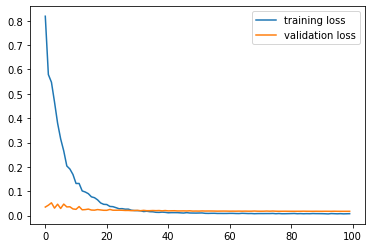

In [41]:
#Plotting training loss and validation loss

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()

# Reading forecast CSV file

In [42]:
forecast_df = pd.read_csv('forecast.csv',index_col='time', sep=';')
forecast_df.head()

,ptime,windspeed [m/s],power [relative]
time,,,
2019-12-21 01:00:00,2019-12-21,7.29,0.14
2019-12-21 02:00:00,2019-12-21,7.07,0.17
2019-12-21 03:00:00,2019-12-21,7.27,0.20
2019-12-21 04:00:00,2019-12-21,7.46,0.15
2019-12-21 05:00:00,2019-12-21,6.89,0.26


In [43]:
forecast_df = forecast_df.rename(columns={'windspeed [m/s]':'windspeed','power [relative]':'power'})

In [45]:
#creating test and true labels
X_test = forecast_df.loc[:,['windspeed']]
print(X_test.shape)

y_test = forecast_df.loc[:,['power']]
y_test.head()

(270, 1)


,power
time,
2019-12-21 01:00:00,0.14
2019-12-21 02:00:00,0.17
2019-12-21 03:00:00,0.20
2019-12-21 04:00:00,0.15
2019-12-21 05:00:00,0.26


predicting power from the test dataframe

In [46]:
#predicting power from the model created.
y_pred = model.predict(X_test)


9/9 [==============================] - 0s 419us/step


In [47]:
y_pred.shape

(270, 1)

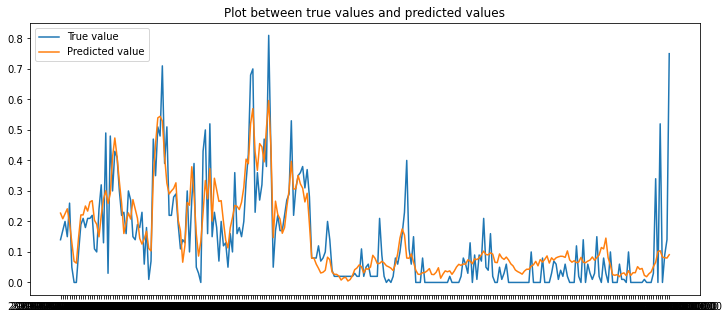

In [48]:
#Plotting true values and predicted power values
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True value')
plt.plot(y_pred, label= 'Predicted value')
plt.title('Plot between true values and predicted values')
plt.legend()

# Model with LSTM

In [49]:
model2 = keras.Sequential()

model2.add(layers.Embedding(input_dim=1000,output_dim=64))

model2.add(layers.LSTM(128, dropout=0.2, recurrent_dropout = 0.2))

model2.add(layers.Dense(1))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.build()

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 162,945
Trainable params: 162,945
Non-trainable params: 0
_________________________________________________________________


In [50]:
history2 = model2.fit(X_train,
           y_train,
            shuffle=False,
           batch_size=32,
           epochs=100,
           validation_split=0.2,
           verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 0.0349 - val_loss: 0.0733
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0522
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0425
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0370
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0334
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0316
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0307
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0299
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0296
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0291
Epoch 11/

31/31 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0289
Epoch 84/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0288
Epoch 85/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0288
Epoch 86/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0287
Epoch 87/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0289
Epoch 88/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0288
Epoch 89/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0289
Epoch 90/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0288
Epoch 91/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0287
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0288
Epoch 93/100


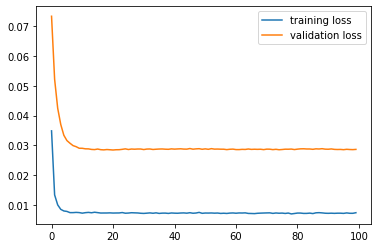

In [63]:
#Plotting training loss and validation loss
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')

plt.legend()

From the plot above, we can say the model is overfitting as validation loss higher than training loss.

In [54]:
y_pred_lstm = model2.predict(X_test)

9/9 [==============================] - 0s 535us/step


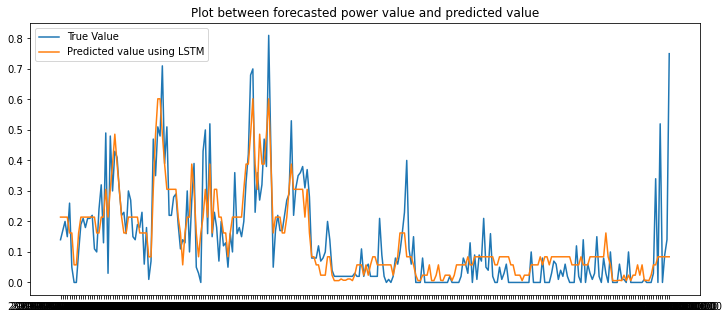

In [56]:
#Plotting true values and predicted power values
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred_lstm, label= 'Predicted value using LSTM')
plt.title('Plot between forecasted power value and predicted value')
plt.legend()

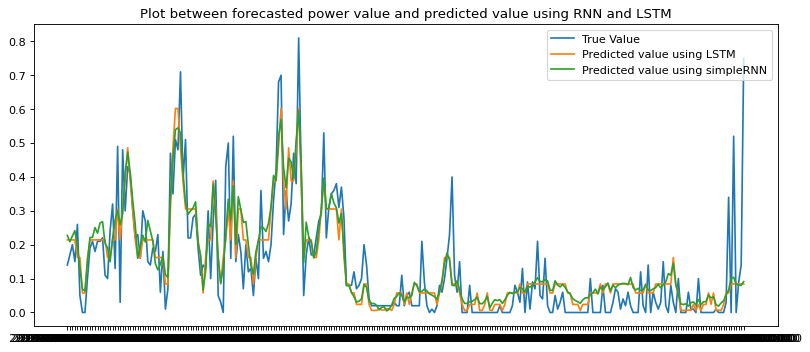

In [60]:
#Plotting true values and predicted power values
plt.figure(figsize=(12, 5), dpi=80)
plt.plot(y_test, label='True Value')
plt.plot(y_pred_lstm, label= 'Predicted value using LSTM')
plt.plot(y_pred, label= 'Predicted value using simpleRNN')
plt.title('Plot between forecasted power value and predicted value using RNN and LSTM')
plt.legend()

Error Calculation and comparision

In [69]:
error_using_RNN = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print('Error using simple RNN : %.4f'%error_using_RNN)

error_using_lstm = np.sqrt(np.sum((y_test-y_pred_lstm)**2)/len(y_test))
print('Error using LSTM : %.4f'%error_using_lstm)

Error using simple RNN : 0.0908
Error using LSTM : 0.0903


# Conclusion

As shown from the above plots and error between two different models. 
Model with LSTM(error: 0.0903) and simple RNN(error: 0.0908). Altough the error between LSTM and RNN are similar, RNN is the better for this dataset as LSTM model is overfitting.